In [1]:
%%bash
rm -R ./cython_galaxy_extended_single_step

In [2]:
import os
os.mkdir('./cython_galaxy_extended_single_step')

In [3]:
%%file ./cython_galaxy_extended_single_step/abstand.pxd
cdef void Abstand (double [:, :], double[:, :], int, int) nogil

Writing ./cython_galaxy_extended_single_step/abstand.pxd


In [4]:
%%file ./cython_galaxy_extended_single_step/abstand.pyx
cimport cython
#Abstands Funktion
#Abstand_Sonne = position[1] - position[0]

@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Abstand (double [:, :] position_view , double[:, :] temp_view, int head, int tail) nogil:  
    
    #index distance 0
    temp_view[0][0] = position_view[head][0] - position_view[tail][0]
    temp_view[0][1] = position_view[head][1] - position_view[tail][1]
    temp_view[0][2] = position_view[head][2] - position_view[tail][2]

Writing ./cython_galaxy_extended_single_step/abstand.pyx


In [5]:
%%file ./cython_galaxy_extended_single_step/betrag.pxd
cdef void Betrag (double[:, :]) nogil

Writing ./cython_galaxy_extended_single_step/betrag.pxd


In [6]:
%%file ./cython_galaxy_extended_single_step/betrag.pyx
cimport cython
from libc.math cimport sqrt


#Betrags Funktion
#Betrag_Erde  = sqrt( Abstand_Erde**2 + Abstand_Erde**2 + Abstand_Erde**2)
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Betrag (double [:, :] temp_view) nogil:
    
    #index magnitude 1
    temp_view[1][0] = sqrt(temp_view[0][0]**2 + temp_view[0][1]**2 + temp_view[0][2]**2)

Writing ./cython_galaxy_extended_single_step/betrag.pyx


In [7]:
%%file ./cython_galaxy_extended_single_step/kraft.pxd
cdef void Kraft (double [:], int, int, double[:, :]) nogil

Writing ./cython_galaxy_extended_single_step/kraft.pxd


In [8]:
%%file ./cython_galaxy_extended_single_step/kraft.pyx
cimport cython

#Kraft Funktion
#Kraft_Erde = G * (masse_erde * masse_sonne / (Betrag_Erde  ** 3)) * Abstand_Erde
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Kraft (double [:] masse_view, int head, int tail, double[:, :] temp_view) nogil:
    
    cdef double g1 = 6.672
    cdef double g2 = 10
    cdef double g3 = -11
    
    cdef double G = g1 * g2 ** g3
    
    #index magnitude 1
    cdef double betrag = temp_view[1][0] ** 3

    cdef double masse_multyply = masse_view[head] * masse_view[tail]
    
    #index distance 0
    #index single_force 2
    temp_view[2][0] = G * (masse_multyply / betrag) * temp_view[0][0]
    temp_view[2][1] = G * (masse_multyply / betrag) * temp_view[0][1]
    temp_view[2][2] = G * (masse_multyply / betrag) * temp_view[0][2]

Writing ./cython_galaxy_extended_single_step/kraft.pyx


In [9]:
%%file ./cython_galaxy_extended_single_step/beschleunigung.pxd
cdef void Beschleunigung (double [:], int, double[:, :]) nogil

Writing ./cython_galaxy_extended_single_step/beschleunigung.pxd


In [10]:
%%file ./cython_galaxy_extended_single_step/beschleunigung.pyx
cimport cython

#Beschleunigungs Funktion
#Beschleunigung_Erde  = Kraft_Erde  / masse
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Beschleunigung (double [:] masse_view, int massen_index, double[:, :] temp_view) nogil:
    cdef float G = 6.672 * 10 ** -11
    
    #index single_force 2
    #index acceleration 4
    temp_view[4][0] = temp_view[2][0]  / masse_view[massen_index]
    temp_view[4][1] = temp_view[2][1]  / masse_view[massen_index]
    temp_view[4][2] = temp_view[2][2]  / masse_view[massen_index]

Writing ./cython_galaxy_extended_single_step/beschleunigung.pyx


In [11]:
%%file ./cython_galaxy_extended_single_step/update_position.pxd
cdef void update_position (double [:, :], double [:, :], double [:, :], double [:, :], double, int) nogil

Writing ./cython_galaxy_extended_single_step/update_position.pxd


In [12]:
%%file ./cython_galaxy_extended_single_step/update_position.pyx
cimport cython

#Positions Aktualliersierung
#position = position + dt * geschwindigkeit  + ((dt ** 2) / 2) * Beschleunigung_Erde
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void update_position (double [:, :] position_view , double [:, :] new_postion_view, \
                   double [:, :] speed_view, double [:, :] temp_view, \
                        double dt, int planet_index) nogil:
    
    #index acceleration 4
    new_postion_view[planet_index][0] = position_view[planet_index][0]  + dt * speed_view[planet_index][0] \
                                                + ((dt ** 2) / 2) * temp_view[4][0]
        
    new_postion_view[planet_index][1] = position_view[planet_index][1]  + dt * speed_view[planet_index][1] \
                                                + ((dt ** 2) / 2) * temp_view[4][1]
        
    new_postion_view[planet_index][2] = position_view[planet_index][2]  + dt * speed_view[planet_index][2] \
                                                + ((dt ** 2) / 2) * temp_view[4][2]

Writing ./cython_galaxy_extended_single_step/update_position.pyx


In [13]:
%%file ./cython_galaxy_extended_single_step/update_speed.pxd
cdef void update_speed (double [:, :], double [:, :], double [:, :], double, int) nogil

Writing ./cython_galaxy_extended_single_step/update_speed.pxd


In [14]:
%%file ./cython_galaxy_extended_single_step/update_speed.pyx
cimport cython

#Geschwindigkeits Aktuallisierung
#geschwindigkeit[0][0]  += dt * Beschleunigung_Erde[0]
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void update_speed (double [:, :] speed_view, double [:, :] new_speed_view, \
                        double [:, :] temp_view, double dt ,int planet_index) nogil:
    
    #index acceleration 4
    new_speed_view[planet_index][0] = speed_view[planet_index][0] + dt * temp_view[4][0]
    new_speed_view[planet_index][1] = speed_view[planet_index][1] + dt * temp_view[4][1]
    new_speed_view[planet_index][2] = speed_view[planet_index][2] + dt * temp_view[4][2]

Writing ./cython_galaxy_extended_single_step/update_speed.pyx


In [15]:
%%file ./cython_galaxy_extended_single_step/calculate_step.pxd
cpdef void calculate_step(double [:, :], double [:, :], double [:, :], double [:, :], \
                          double [:], double [:, :], double, int, int, int)

Writing ./cython_galaxy_extended_single_step/calculate_step.pxd


In [16]:
%%file ./cython_galaxy_extended_single_step/calculate_step.pyx
from cython.parallel import prange
from abstand cimport Abstand
from betrag cimport Betrag
from kraft cimport Kraft
from beschleunigung cimport Beschleunigung
from update_position cimport update_position
from update_speed cimport update_speed
import numpy as np
cimport cython

@cython.boundscheck(False)
cpdef void calculate_step(double [:, :] position_view, double [:, :] speed_view, \
                          double [:, :] new_position_view, double [:, :] new_speed_view, \
                          double [:] masse_view, double [:, :] temp_view, \
                          double dt, int target_planet, int upper, int lower):

    #Statische Variable
    cdef int planet
    
    #index distance 0
    #index magnitude 1
    #index single_force 2
    #index all_force 3
    #index acceleration 4
    
    temp_view[3][0] = 0
    temp_view[3][1] = 0
    temp_view[3][2] = 0
    
    for planet in prange(lower, upper, nogil=True):      
        if (planet != target_planet):
            Abstand(position_view, temp_view, planet, target_planet)              
            Betrag(temp_view)
            Kraft(masse_view, planet, target_planet, temp_view)
            temp_view[3][0] += temp_view[2][0]
            temp_view[3][1] += temp_view[2][1]
            temp_view[3][2] += temp_view[2][2]
            
    Beschleunigung(masse_view, target_planet, temp_view)
    update_position(position_view, new_position_view, speed_view, temp_view, dt, target_planet) 
    update_speed(speed_view , new_speed_view, temp_view, dt, target_planet)   

Writing ./cython_galaxy_extended_single_step/calculate_step.pyx


In [17]:
%%file ./cython_galaxy_extended_single_step/loop.pyx
from calculate_step cimport calculate_step
from calculate_step import calculate_step
import numpy as np
cimport cython

@cython.boundscheck(False)
cpdef Loop (args_dt, args_iteration, python_position, python_speed, python_masse, pos_list):
    
    #Umwandeln in Numpy Arrays
    position = np.array(python_position, dtype=np.float64)
    speed = np.array(python_speed, dtype=np.float64)
    masse = np.array(python_masse, dtype=np.float64)

    #Umwandlung in MemoryView
    cdef double [:, :] position_view = position
    cdef double [:, :] speed_view = speed
    cdef double [:, :] new_position_view = position
    cdef double [:, :] new_speed_view = speed 
    cdef double [:] masse_view = masse

    #Statische Variable
    cdef double dt = args_dt
    cdef int number_planets = len(python_position)
    cdef int i, current_planet, list_index
    cdef int iteration = args_iteration
    
    #Dynamische Variable
    cdef double [:, :]  temp_view = np.arange(15, dtype=np.dtype("d")).reshape((5, 3))
            
    for i in range (iteration): 
        for current_planet in range (number_planets):
            calculate_step(position_view, speed_view, new_position_view, \
            new_speed_view, masse_view, temp_view, dt, current_planet, number_planets, 0)
        
        position_view = new_position_view
        speed_view = new_speed_view
        
        pos_list_entry = []
        for list_index in range(number_planets):
            pos_list_entry.append(np.array((position_view[list_index][0], position_view[list_index][1],\
            position_view[list_index][2]), np.float64))
        
        pos_list.append(np.array(pos_list_entry, np.float64))

Writing ./cython_galaxy_extended_single_step/loop.pyx


In [18]:
%%file ./cython_galaxy_extended_single_step/setup.py


# Aufruf: python3 setup.py build_ext --inplace
# Windows: zusaetzliche Option --compiler=mingw32
from distutils.core import setup
from distutils.extension import Extension
from Cython.Distutils import build_ext
import numpy


ext_modules=[ Extension("abstand", ["abstand.pyx"],
                extra_compile_args=['-O3'], libraries=['m']),
             
             Extension("betrag", ["betrag.pyx"],
                extra_compile_args=['-O3'], libraries=['m']),
             
              Extension("kraft", ["kraft.pyx"],
                extra_compile_args=['-O3'], libraries=['m']),
             
             Extension("beschleunigung", ["beschleunigung.pyx"],
                extra_compile_args=['-O3'], libraries=['m']),
             
             Extension("update_position", ["update_position.pyx"],
                extra_compile_args=['-O3'], libraries=['m']),
             
             Extension("update_speed", ["update_speed.pyx"],
                extra_compile_args=['-O3'], libraries=['m']),
             
             Extension("calculate_step", ["calculate_step.pyx"],
                extra_compile_args=['-O3', '-fopenmp'], libraries=['m'],
                extra_link_args=['-fopenmp'],),
             
             Extension("loop", ["loop.pyx"],
                extra_compile_args=['-O3'], libraries=['m'])
        
        #Maybe needed
        #extra_compile_args=['-O3'], libraries=['m'],
        #include_dirs=[numpy.get_include()]),
]
             
setup( name = 'cython demo',
  cmdclass = {'build_ext': build_ext},
  ext_modules = ext_modules,
     include_dirs=[numpy.get_include()])



Writing ./cython_galaxy_extended_single_step/setup.py


## Compile Cython

In [19]:
%%bash
cd ./cython_galaxy_extended_single_step
#Compilen
python3 setup.py build_ext --inplace

running build_ext
cythoning abstand.pyx to abstand.c
building 'abstand' extension
creating build
creating build/temp.linux-x86_64-3.6
gcc -pthread -B /opt/anaconda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/anaconda/lib/python3.6/site-packages/numpy/core/include -I/opt/anaconda/include/python3.6m -c abstand.c -o build/temp.linux-x86_64-3.6/abstand.o -O3
gcc -pthread -shared -B /opt/anaconda/compiler_compat -L/opt/anaconda/lib -Wl,-rpath=/opt/anaconda/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.6/abstand.o -L/opt/anaconda/lib -lm -lpython3.6m -o /home/shiroten/Nextcloud/Studium Dokumente/Aktuelles Semester/Rösch - Programmieren 3/Planetary-Python-Project/Source/Shiroten/cython_galaxy_extended_single_step/abstand.cpython-36m-x86_64-linux-gnu.so
cythoning betrag.pyx to betrag.c
building 'betrag' extension
gcc -pthread -B /opt/anaconda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -

## Start in Juypter

In [20]:
%load_ext Cython

In [34]:
#Sonnesystem

python_position = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [57_909_175_000, 0, 0], 
    #"Venus"
    [108_208_930_000, 0, 0],    
    #"Earth"
    [149_597_890_000, 0, 0],    
    #"Moon"
    [149_597_890_000, 384_400_000, 0],    
    #"Mars"
    [227_936_640_000, 0, 0],    
    #"Jupiter"
    [778_412_020_000, 0, 0],    
    #"Saturn"
    [1_426_725_400_000, 0, 0],    
    #"Uranus"
    [2_870_972_200_000, 0, 0],    
    #"Neptune"
    [4_498_252_900_000, 0, 0]
]

python_geschwindigkeit = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [0, 47_872, 0], 
    #"Venus"
    [0, 35_021, 0],    
    #"Earth"
    [0, 29_786, 0],    
    #"Moon"
    [-1_022, 0, 0],    
    #"Mars"
    [0, 24_131, 0],    
    #"Jupiter"
    [0, 13_069, 0],    
    #"Saturn"
    [0, 9_672, 0],    
    #"Uranus"
    [0, 6_835, 0],    
    #"Neptune"
    [0, 5_477, 0]
]

python_masse = [
    #"Sun"
    1.9889 * 10 ** 30,     
    #"Mercury"
    3.3022 * 10 ** 23, 
    #"Venus"
    4.8685 * 10 ** 24,    
    #"Earth"
    5.97219 * 10 ** 24,    
    #"Moon"
    7.34767309 * 10 ** 22,    
    #"Mars"
    6.4185 * 10 ** 23,    
    #"Jupiter"
    1.8987 * 10 ** 27,    
    #"Saturn"
    5.6851 * 10 ** 26,    
    #"Uranus"
    8.6849 * 10 ** 25,    
    #"Neptune"
    1.0244 * 10 ** 26
]

In [31]:
#Erde und Sonne alleine

python_position = [
    #"Sun"
    [0, 0, 0],       
    #"Earth"
    [149_597_890_000, 0, 0]
]

python_geschwindigkeit = [
    #"Sun"
    [0, 0, 0],      
    #"Earth"
    [0, 29_786, 0]   
]

python_masse = [
    #"Sun"
    1.9889 * 10 ** 30,     
    #"Earth"
    5.97219 * 10 ** 24
]

In [35]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append("./cython_galaxy_extended_single_step")

from loop import Loop
import matplotlib.pyplot as plt

plot_list = []
year = 60 * 60 * 24 * 365 * 5
dt = 60 * 60
iteration = year / dt
Loop(dt, iteration, python_position, python_geschwindigkeit, python_masse, plot_list)

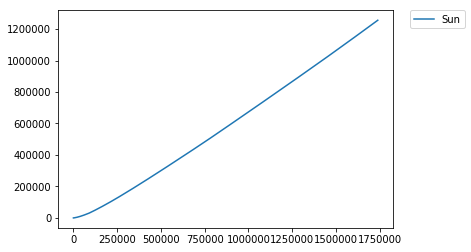

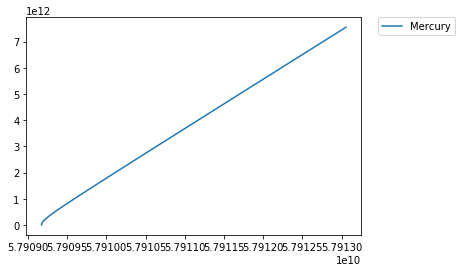

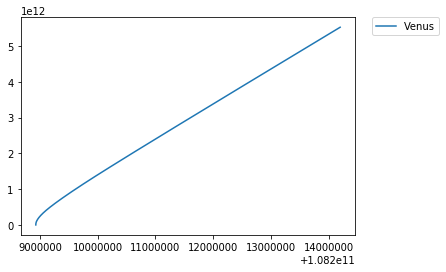

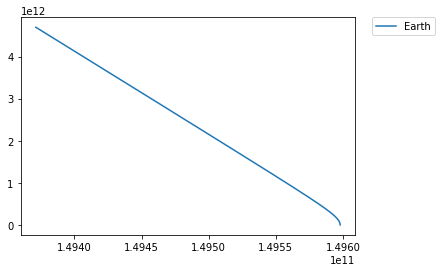

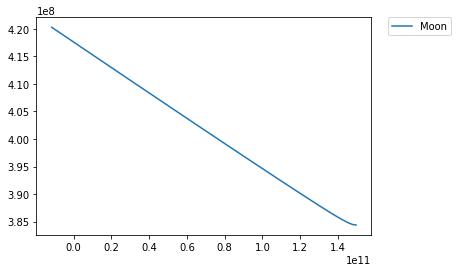

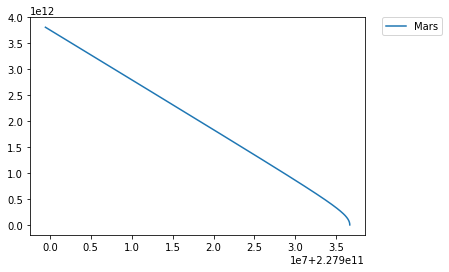

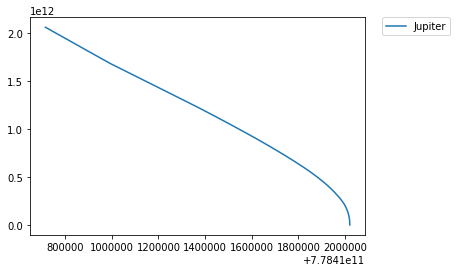

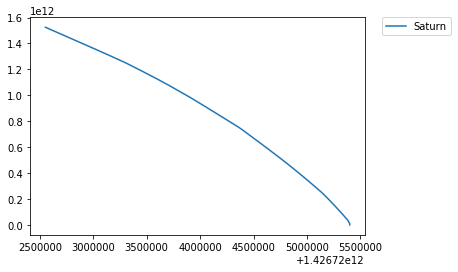

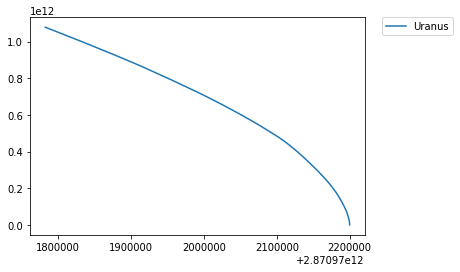

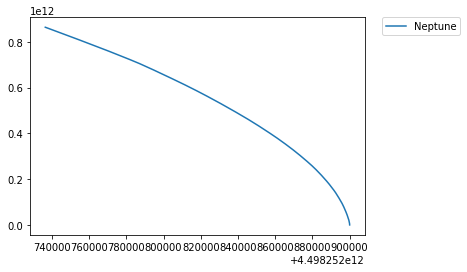

plot_list_length 43800
[ 0.12075034  0.          0.        ]
[  4.83001364e-01   2.94690924e-06   0.00000000e+00]
[  9.71343891e-01   1.29119949e-05   0.00000000e+00]
[  1.47036874e+00   3.30552417e-05   0.00000000e+00]
[  1.98007590e+00   6.74478956e-05   0.00000000e+00]
[  2.50046535e+00   1.20161184e-04   0.00000000e+00]
[  3.03153706e+00   1.95266310e-04   0.00000000e+00]
[  3.57329102e+00   2.96834447e-04   0.00000000e+00]
[  4.12572718e+00   4.28936735e-04   0.00000000e+00]
[  4.68884551e+00   5.95644274e-04   0.00000000e+00]
[  5.26264596e+00   8.01028117e-04   0.00000000e+00]
[  5.84712850e+00   1.04915927e-03   0.00000000e+00]
[  6.44229307e+00   1.34410868e-03   0.00000000e+00]
[  7.04813960e+00   1.68994723e-03   0.00000000e+00]
[  7.66466806e+00   2.09074574e-03   0.00000000e+00]
[  8.29187836e+00   2.55057497e-03   0.00000000e+00]
[  8.92977043e+00   3.07350558e-03   0.00000000e+00]
[  9.57834422e+00   3.66360815e-03   0.00000000e+00]
[  1.02375996e+01   4.32495320e-03   0

In [38]:
plt.subplot(111)
plt.plot([x[0][0] for x in plot_list], [x[0][1] for x in plot_list], label="Sun")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[1][0] for x in plot_list], [x[1][1] for x in plot_list], label="Mercury")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[2][0] for x in plot_list], [x[2][1] for x in plot_list], label="Venus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[3][0] for x in plot_list], [x[3][1] for x in plot_list], label="Earth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[4][0] for x in plot_list], [x[4][1] for x in plot_list], label="Moon")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[5][0] for x in plot_list], [x[5][1] for x in plot_list], label="Mars")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[6][0] for x in plot_list], [x[6][1] for x in plot_list], label="Jupiter")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[7][0] for x in plot_list], [x[7][1] for x in plot_list], label="Saturn")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[8][0] for x in plot_list], [x[8][1] for x in plot_list], label="Uranus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[9][0] for x in plot_list], [x[9][1] for x in plot_list], label="Neptune")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print("plot_list_length", len(plot_list))
for _ in range (50):
    print(plot_list[_][0])

## Start as File

In [ ]:
%%file ./cython_galaxy_extended_single_step/start.py
from loop import Loop
import matplotlib.pyplot as plt

#Sonnesystem

python_position = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [57_909_175_000, 0, 0], 
    #"Venus"
    [108_208_930_000, 0, 0],    
    #"Earth"
    [149_597_890_000, 0, 0],    
    #"Moon"
    [149_597_890_000, 384_400_000, 0],    
    #"Mars"
    [227_936_640_000, 0, 0],    
    #"Jupiter"
    [778_412_020_000, 0, 0],    
    #"Saturn"
    [1_426_725_400_000, 0, 0],    
    #"Uranus"
    [2_870_972_200_000, 0, 0],    
    #"Neptune"
    [4_498_252_900_000, 0, 0]
]

python_geschwindigkeit = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [0, 47_872, 0], 
    #"Venus"
    [0, 35_021, 0],    
    #"Earth"
    [0, 29_786, 0],    
    #"Moon"
    [-1_022, 0, 0],    
    #"Mars"
    [0, 24_131, 0],    
    #"Jupiter"
    [0, 13_069, 0],    
    #"Saturn"
    [0, 9_672, 0],    
    #"Uranus"
    [0, 6_835, 0],    
    #"Neptune"
    [0, 5_477, 0]
]

python_masse = [
    #"Sun"
    1.9889 * 10 ** 30,     
    #"Mercury"
    3.3022 * 10 ** 23, 
    #"Venus"
    4.8685 * 10 ** 24,    
    #"Earth"
    5.97219 * 10 ** 24,    
    #"Moon"
    7.34767309 * 10 ** 22,    
    #"Mars"
    6.4185 * 10 ** 23,    
    #"Jupiter"
    1.8987 * 10 ** 27,    
    #"Saturn"
    5.6851 * 10 ** 26,    
    #"Uranus"
    8.6849 * 10 ** 25,    
    #"Neptune"
    1.0244 * 10 ** 26
]

plot_list = []
iteration = 60 * 24 * 365 * 2
Loop(iteration, python_position, python_geschwindigkeit, python_masse, plot_list)

plt.subplot(111)
plt.plot([x[0][0] for x in plot_list], [x[0][1] for x in plot_list], label="Sun")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[1][0] for x in plot_list], [x[1][1] for x in plot_list], label="Mercury")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[2][0] for x in plot_list], [x[2][1] for x in plot_list], label="Venus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[3][0] for x in plot_list], [x[3][1] for x in plot_list], label="Earth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[4][0] for x in plot_list], [x[4][1] for x in plot_list], label="Moon")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[5][0] for x in plot_list], [x[5][1] for x in plot_list], label="Mars")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[6][0] for x in plot_list], [x[6][1] for x in plot_list], label="Jupiter")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[7][0] for x in plot_list], [x[7][1] for x in plot_list], label="Saturn")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[8][0] for x in plot_list], [x[8][1] for x in plot_list], label="Uranus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[9][0] for x in plot_list], [x[9][1] for x in plot_list], label="Neptune")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print("plot_list_length", len(plot_list))
for _ in range (40):
    print(plot_list[_])

In [ ]:
%%bash
cd cython_galaxy_extended_single_step
python3 start.py